In [1]:
import sys

import torch
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader, Dataset, random_split

from utils.logging import setup_logging

sys.setrecursionlimit(20000)
setup_logging()

In [2]:
import pickle

with open("ASTBERTa/data.pkl", "rb") as f:
  data = pickle.load(f)

with open("ASTBERTa/vocab_data.pkl", "rb") as f:
  vocab_data = pickle.load(f)

token_to_id = vocab_data["token_to_id"]
id_to_token = vocab_data["id_to_token"]
special_token_ids = vocab_data["special_token_ids"]
vocab = vocab_data["vocab"]
frag_type_to_ids = vocab_data["frag_type_to_ids"]
frag_id_to_type = vocab_data["frag_id_to_type"]


for key, value in tqdm.tqdm(frag_type_to_ids.items()):
  frag_type_to_ids[key] = torch.tensor(value, dtype=torch.long)

100%|██████████| 54/54 [00:00<00:00, 3756.78it/s]


In [3]:
PAD_TOKEN = "<pad>"
CLS_TOKEN = "<s>"
SEP_TOKEN = "</s>"
MASK_TOKEN = "<mask>"
UNK_TOKEN = "<unk>"

special_tokens = [PAD_TOKEN, CLS_TOKEN, MASK_TOKEN, SEP_TOKEN, UNK_TOKEN]


class FragDataset(Dataset[list[int]]):
  def __init__(self, data: list[list[int]]):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int) -> list[int]:
    return self.data[index]

In [4]:
MAX_SEQ_LEN = 512
MLM_PROB = 0.15

def seq_data_collator(
    batch: list[list[int]]
) -> dict[str, torch.Tensor]:
    seqs: list[torch.Tensor] = []

    for x in batch:
        if torch.rand(1).item() < 0.75:
            random_start_idx = torch.randint(low = 2, high=len(x), size =(1,)).item()
            seq = [token_to_id[CLS_TOKEN]] + x[random_start_idx:random_start_idx+MAX_SEQ_LEN-1]
        else:
            seq = x[:MAX_SEQ_LEN] 
        
        assert len(seq) <= MAX_SEQ_LEN
        seqs.append(torch.tensor(seq))
    


    inputs = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True)

    labels = inputs.clone()

    special_token_mask = torch.zeros_like(labels).float()
    special_token_mask[(labels >= 0) & (labels <= len(special_tokens))] = 1.0
    special_token_mask = special_token_mask.bool()

    probability_matrix = torch.full(labels.shape, MLM_PROB)
    probability_matrix.masked_fill_(special_token_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = (
        torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    )
    inputs[indices_replaced] = token_to_id[MASK_TOKEN]
    labels[~masked_indices] = -100

    # 10% of the time, we replace masked input tokens with random word
    indices_random = (
        torch.bernoulli(torch.full(labels.shape, 0.5)).bool()
        & masked_indices
        & ~indices_replaced
    )
    random_words = torch.randint(len(vocab), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    attention_mask = torch.ones_like(inputs, dtype=torch.float)
    attention_mask[inputs == token_to_id[PAD_TOKEN]] = 0.0

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return {
        "input_ids": inputs,
        "labels": labels,
        "attention_mask": attention_mask,
    }



In [5]:
from transformers import RobertaForMaskedLM, RobertaModel, RobertaConfig


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

vocab_size = len(vocab)  # size of vocabulary
intermediate_size = 3072  # embedding dimension
hidden_size = 768

num_hidden_layers = 6
num_attention_heads = 12
dropout = 0.1

batch_size = 8
top_k = 64

dataset = FragDataset(data)
train_split, val_split, test_split = random_split(dataset, [0.8, 0.1, 0.1])

train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True, collate_fn=seq_data_collator)
val_loader = DataLoader(val_split, batch_size=batch_size, shuffle=True, collate_fn=seq_data_collator)
test_loader = DataLoader(test_split, batch_size=batch_size, shuffle=True, collate_fn=seq_data_collator)

config = RobertaConfig(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    intermediate_size=intermediate_size,
    hidden_dropout_prob=dropout,
    max_position_embeddings=MAX_SEQ_LEN+2,
    pad_token_id=token_to_id[PAD_TOKEN],
    bos_token_id=token_to_id[CLS_TOKEN],
    eos_token_id=token_to_id[SEP_TOKEN]
)
model = RobertaForMaskedLM(config).to(device)

print(
    f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters"
)
print(model)


/home/pranav/.cache/pypoetry/virtualenvs/js-rl-vfj9GiAe-py3.11/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The model has 59,313,982 trainable parameters
RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(20542, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features

In [6]:
from pathlib import Path
from typing import Any

import tqdm

MODEL_SAVE_PATH = "ASTBERTa/models-l1/"

def evaluate_batch(model: RobertaForMaskedLM, batch: dict[str, Any]) -> torch.Tensor:
    input_ids = batch["input_ids"].to(device)
    labels = batch["labels"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    out = model(input_ids, attention_mask=attention_mask, labels=labels)

    return out.loss



def evaluate(model: RobertaForMaskedLM, val_loader: DataLoader[list[int]]):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(val_loader):
            loss = evaluate_batch(model, batch)
            total_loss += loss.item()

    return total_loss / len(val_loader)


def train(
    model: RobertaForMaskedLM,
    train_loader: DataLoader[list[int]],
    val_loader: DataLoader[list[int]],
    optim: torch.optim.Optimizer,
    model_save_path: Path = Path(MODEL_SAVE_PATH),
    epochs: int = 8,
):
    steps = 0

    train_losses = []
    val_losses = []

    for epoch in (pbar := tqdm.trange(epochs)):
        model.train()
        epoch_loss = 0
        per_batch_loss = []
        for _, batch in (
            ibar := tqdm.tqdm(
                enumerate(train_loader), leave=True, total=len(train_loader)
            )
        ):
            optim.zero_grad()
            loss = evaluate_batch(model, batch)
            loss.backward()
            optim.step()
            steps += 1

            epoch_loss += loss.item()
            per_batch_loss.append(loss.item())
            # print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")
            ibar.set_postfix({"loss": loss.item()})

            if steps % 500 == 0:
                torch.save(model, model_save_path / f"model_{steps}.pt")

        val_loss = evaluate(model, val_loader)
        pbar.set_postfix(
            {"val_loss": val_loss, "train_loss": epoch_loss / len(train_loader)}
        )
        print(
            f"Epoch: {epoch}, Val Loss: {val_loss}, Train Loss: {epoch_loss / len(train_loader)}"
        )

        train_losses.append(per_batch_loss)
        val_losses.append(val_loss)

        pickle.dump(train_losses, open(model_save_path / "train_losses.pkl", "wb"))
        pickle.dump(val_losses, open(model_save_path / "val_losses.pkl", "wb"))

In [7]:
optim = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=0.01,
    betas=(0.9, 0.98),
)

train(model, train_loader, val_loader, optim)


  0%|          | 0/8 [00:04<?, ?it/s]


KeyboardInterrupt: 

<Axes: >

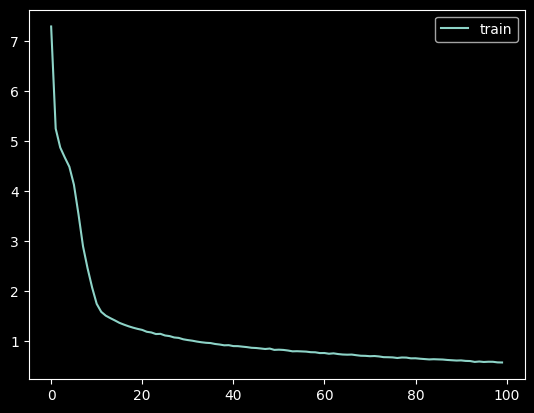

In [28]:
import seaborn as sns
import numpy as np
import pickle

with open("ASTBERTa/models/sub-sequence/train_losses.pkl", "rb") as f:
    train_losses = pickle.load(f)
  
with open("ASTBERTa/models/sub-sequence/val_losses.pkl", "rb") as f:
    val_losses = pickle.load(f)

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

N = train_losses.shape[0]


sns.lineplot(x=np.arange(0, N), y=train_losses.mean(axis=1), label="train")
sns.lineplot(x=np.arange(0, N), y=val_losses, label="val")

In [15]:
dp_model = torch.load("ASTBERTa/models/final/model_28000.pt")
model = dp_model.to(device)

In [16]:
import esprima
from js_ast.nodes import Node
from js_ast.fragmentise import frag_to_str, node_to_frags, hash_frag

code = """
function foo() {
    var a = 1;
    var b = 2;
}
"""

ast = esprima.parseScript(code)
ast = Node.from_dict(ast.toDict())


frag_seq = []
frag_info_seq = []
node_types = set()


node_to_frags(ast, frag_seq, frag_info_seq, node_types)
frags_str = [frag_to_str(frag) for frag in frag_seq]

In [17]:
print(frags_str)

["('type', 'Program')('sourceType', 'script')[('type', 'FunctionDeclaration')]", "('type', 'FunctionDeclaration'){('type', 'Identifier')}[]('generator', False)('isAsync', False)('expression', False){('type', 'BlockStatement')}", "('type', 'Identifier')('name', 'foo')", "('type', 'BlockStatement')[('type', 'VariableDeclaration'),('type', 'VariableDeclaration')]", "('type', 'VariableDeclaration')[('type', 'VariableDeclarator')]('kind', 'var')", "('type', 'VariableDeclarator'){('type', 'Identifier')}{('type', 'Literal')}", "('type', 'Identifier')('name', 'a')", "('type', 'Literal')('value', 1)('raw', '1')('regex', None)('bigint', None)", "('type', 'VariableDeclaration')[('type', 'VariableDeclarator')]('kind', 'var')", "('type', 'VariableDeclarator'){('type', 'Identifier')}{('type', 'Literal')}", "('type', 'Identifier')('name', 'b')", "('type', 'Literal')('value', 2)('raw', '2')('regex', None)('bigint', None)"]


In [24]:
frag_seq_ids = [token_to_id[hash_frag(frag)] for frag in frag_seq]
frag_seq_ids = [token_to_id[CLS_TOKEN]] + frag_seq_ids + [token_to_id[SEP_TOKEN]]
k = 4
print(frag_seq_ids[k])
frag_seq_ids[k] = token_to_id[MASK_TOKEN]

frag_seq_ids = torch.tensor(frag_seq_ids, dtype=torch.long).unsqueeze(0).to(device)

print(frag_seq_ids)

out = model(frag_seq_ids).logits
preds = nn.functional.softmax(out, dim=-1)
pred = torch.argmax(preds, dim=-1)

16992
tensor([[    1,  8312, 10449,  9308,     2,  3305,  5516, 11618, 11153,  3305,
          5516,  1327,  8643,     3]], device='cuda:0')


In [25]:
print(pred)

tensor([[ 1294,  8312, 10449,  8698,  4659,  3305,  5516, 11618, 11153,  3305,
          5516,  1327,  8643,    12]], device='cuda:0')


In [15]:
t = [
    [1, 2, 5, 6, 0, 0],
    [2, 3, 5, 0, 0, 0],
    [1, 2, 3, 4, 5, 6],
]

# t = 
# print(t)

In [9]:
config = RobertaConfig(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    intermediate_size=intermediate_size,
    hidden_dropout_prob=dropout,
    max_position_embeddings=1026,
)
ast_net = RobertaModel(config).to(device)


In [16]:
ast_net(input_ids=torch.tensor(t, dtype=torch.long).to(device))

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 6.1722e-01,  4.3260e-01,  1.5933e-01,  ...,  7.3708e-01,
           4.6374e-01,  1.1797e-01],
         [ 8.8787e-01,  8.1163e-01,  1.0322e+00,  ...,  3.8541e-01,
           3.7509e-02, -1.1324e+00],
         [ 2.2646e-01, -1.1131e+00,  1.8539e-01,  ...,  8.4913e-01,
           1.5349e-01, -5.2603e-01],
         [ 6.2816e-01,  6.4152e-01, -8.3964e-01,  ...,  3.9646e-01,
           5.3345e-01,  1.8185e-01],
         [ 7.1551e-01,  4.8978e-01,  1.2540e+00,  ...,  3.0588e-01,
          -1.2160e-02, -4.7937e-01],
         [ 6.9145e-01,  2.3819e-01, -2.1357e-01,  ..., -7.7907e-02,
           4.3772e-01, -1.0086e+00]],

        [[ 6.8574e-01,  4.0473e-01,  5.9456e-01,  ...,  3.3835e-01,
           1.0181e-03, -1.3227e-01],
         [ 2.3013e+00, -1.9017e-02,  1.4823e+00,  ...,  1.9135e-01,
           6.0835e-01,  5.7279e-01],
         [-5.1198e-01,  7.0884e-01,  6.3066e-01,  ...,  1.8414e-01,
          -1.3327e+00, -4.8